## Các Biến Kiểm soát Có Lợi

Chúng ta đã thấy làm thế nào mà việc thêm các biến kiểm soát vào mô hình hồi quy giúp ta có thể xác định tác động nhân quả. Nếu biến kiểm soát là một biến nhiễu, việc thêm nó vào mô hình không chỉ để đẹp đội hình, mà là một bắt buộc. Nếu thiếu thận trọng khi xem xét vấn đề này, phản ứng tự nhiên là ta sẽ ném bất cứ thứ gì có thể đo lường được vào mô hình. Ngày nay với dữ liệu lớn, ta dễ dàng có hơn 1000 biến. Hóa ra, điều này không những không cần thiết mà còn có thể gây bất lợi cho việc xác định quan hệ nhân quả. Bây giờ, ta hãy chuyển sự chú ý sang các biến kiểm soát bên ngoài các biến nhiễu. Trước tiên, hãy xem xét những biến có lợi. Sau đó, chúng ta sẽ đi sâu vào các biến kiểm soát có hại.

Một ví dụ điển hình, giả sử bạn là một chuyên gia dữ liệu trong một nhóm chuyên về mảng công nghệ tài chính. Nhiệm vụ tiếp theo của bạn là tìm ra tác động của việc gửi thư điện tử yêu cầu mọi người thương lượng khoản vay của họ. Biến phụ thuộc chính là số tiền nhận được từ các khách hàng thanh toán muộn.

Để trả lời câu hỏi này, nhóm của bạn chọn ra 5000 khách hàng ngẫu nhiên từ cơ sở dữ liệu khách hàng thanh toán muộn để thực hiện một thử nghiệm ngẫu nhiên. Đối với mỗi khách hàng, bạn tung một đồng xu, nếu nó là mặt ngửa, khách hàng sẽ được nhận email; nếu không, họ được dùng làm đối chứng. Bằng cách này, bạn hy vọng sẽ tính được mỗi email giúp nhóm thu hồi thêm được bao nhiêu tiền.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import style
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
import graphviz as gr

style.use("fivethirtyeight")

In [2]:
data = pd.read_csv("./data/collections_email.csv")
data.head()

,payments,email,opened,agreement,credit_limit,risk_score
0,740,1,1.0,0.0,2348.495260,0.666752
1,580,1,1.0,1.0,334.111969,0.207395
2,600,1,1.0,1.0,1360.660722,0.550479
3,770,0,0.0,0.0,1531.828576,0.560488
4,660,0,0.0,0.0,979.855647,0.455140


Vì dữ liệu ngẫu nhiên, bạn biết rằng hiệu của các giá trị trung bình giúp ước lượng Tác Động Can Thiệp Trung Bình. Nói cách khác, không gì khác tạo ra sự can thiệp ngoài sự ngẫu nhiên, do đó, các kết quả tiềm năng không phụ thuộc vào sự can thiệp: \\((Y_0, Y_1)\perp T\\). 

$
ATE = E[Y_i|T_i=1] - E[Y_i|T_i=1]
$

Vì bạn hiểu biết và muốn  tính khoảng tin cậy cho ước lượng của mình, bạn sử dụng hồi quy tuyến tính.

In [3]:
print("Difference in means:",
      data.query("email==1")["payments"].mean() - data.query("email==0")["payments"].mean())

model = smf.ols('payments ~ email', data=data).fit()
model.summary().tables[1]

Difference in means: -0.6202804021329484


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,669.9764,2.061,325.116,0.000,665.937,674.016
email,-0.6203,2.941,-0.211,0.833,-6.387,5.146


Đáng buồn thay, ATE được ước lượng là -0,62, một kết quả khá kỳ quặc. Làm thế nào mà việc gửi một email nhắc nhở lại khiến khách hàng thanh toán ít tiền hơn mức trung bình? Tuy nhiên, vì trị số p quá cao nên con số này có thể không có ý nghĩa gì. Bạn nên làm gì bây giờ? Trở lại đồng đội của mình ủ rũ và nói với họ rằng việc kiểm định không có kết quả và bạn cần thêm dữ liệu hay sao? Đừng vội như vậy.

Lưu ý rằng dữ liệu trên có một số cột thú vị khác. Ví dụ: `credit_limit` đại diện cho hạn mức tín dụng của khách hàng trước khi họ quá hạn. `risk_score` tương ứng với rủi ro được ước lượng của khách hàng trước khi gửi email. Thật có lý khi cho rằng hạn mức tín dụng và rủi ro có thể là những yếu tố dự báo rất tốt cho số tiền được thanh toán. Tuy nhiên việc những biến này hữu ích như thế nào vẫn chưa rõ ràng.

Trước tiên, hãy hiểu tại sao chúng ta không tìm thấy ý nghĩa thống kê của can thiệp ngay cả khi có can thiệp. Có thể là việc can thiệp có rất ít tác động đến kết quả, như trong trường hợp này. Bạn nghĩ thử xem, điều gì khiến một người trả nợ, phần lớn là các yếu tố nằm ngoài tầm kiểm soát của phòng thu nợ. Người ta trả nợ bởi họ tìm được công việc mới, quản lý được các khoản tài chính, thu nhập của họ, v.v. Về mặt thống kê, chúng ta có thể nói rằng **sự biến động của lượng thanh toán được giải thích nhiều hơn bởi các yếu tố khác ngoài thư điện tử**.

Để hiểu một cách trực quan về nó, chúng ta có thể vẽ biểu đồ lượng thanh toán theo biến can thiệp email. Tôi cũng đã vẽ đường hồi quy của mô hình trên với màu đỏ. Để hỗ trợ đồ họa, tôi đã thêm chút nhiễu vào biến email để nó không hoàn toàn rơi vào mức 0 hoặc 1.

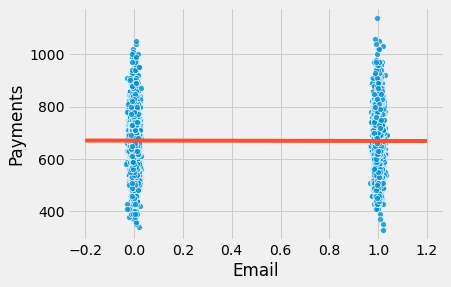

In [4]:
sns.scatterplot("email", "payments", 
                alpha=0.8,
                data=data.assign(email=data["email"] + np.random.normal(0, 0.01, size=len(data["email"]))))
plt.plot(np.linspace(-0.2, 1.2), model.params[0] + np.linspace(-1, 2) * model.params[1], c="C1")
plt.xlabel("Email")
plt.ylabel("Payments");

Chúng ta có thể thấy lượng thanh toán dao động mạnh trong một nhóm được can thiệp. Nhìn trực quan, có vẻ như nó dao động từ dưới 400 một chút cho đến 1000 trong cả hai nhóm. Nếu tác động của thư điện tử rơi vào cỡ 5,00 hoặc 10,00 đồng, không có gì ngạc nhiên khi ta khó có thể nhìn thấy rõ tất cả các dao động.

May mắn thay, hồi quy có thể giúp chúng ta giảm bớt sự dao động này. Bí kíp là sử dụng thêm các biến kiểm soát. **Nếu đây là một biến dự đoán kết quả tốt, nó sẽ cho ta biết rất nhiều về phương sai**. Nếu rủi ro và hạn mức tín dụng là những biến dự đoán tốt cho số tiền được thanh toán, chúng ta có thể kiểm soát chúng để có thể xác định tác động của thư điện tử đối với lượng thanh toán một cách dễ dàng hơn. Nếu chúng ta nhớ cách hoạt động của hồi quy, nó sẽ cho ta một lời giải thích trực quan. Việc thêm nhiều biến vào một hồi quy có nghĩa là ta giữ cho chúng không đổi trong khi xem xét tác động của sự can thiệp. Vì vậy, theo lý thì khi chúng ta xem xét sự tương đồng của mức độ rủi ro và hạn mức tín dụng, thì phương sai của lượng thanh toán trong biến phụ thuộc sẽ nhỏ hơn. Hay nói cách khác, nếu mức độ rủi ro và hạn mức tín dụng dự đoán tốt lượng thanh toán, thì những khách hàng với mức rủi ro và hạn mức tín dụng tương tự cũng phải có mức thanh toán tương tự, do đó có phương sai nhỏ hơn.

![img](./data/img/beyond-conf/y-pred.png)

Để chứng tỏ điều này, chúng ta hãy chia nhỏ phương pháp hồi quy thành 2 bước. Đầu tiên, chúng ta sẽ hồi quy sự can thiệp (email) và kết quả (lượng thanh toán) theo các biến kiểm soát (hạn mức tín dụng và điểm rủi ro). Thứ hai, chúng ta sẽ hồi quy phần dư của sự can thiệp theo phần dư của lượng thanh toán, cả hai đều được thu thập tại bước 1. (Điều này chỉ mang tính sư phạm, trong thực tế, bạn sẽ không cần phải thực hiện tất cả những bước phiền toái này).

In [5]:
model_email = smf.ols('email ~ credit_limit + risk_score', data=data).fit()
model_payments = smf.ols('payments ~ credit_limit + risk_score', data=data).fit()

residuals = pd.DataFrame(dict(res_payments=model_payments.resid, res_email=model_email.resid))

model_treatment = smf.ols('res_payments ~ res_email', data=residuals).fit()

Điều này làm giảm phương sai của biến phụ thuộc. Bằng cách hồi quy lượng thanh toán theo hạn mức tín dụng và rủi ro, rồi lấy phần dư của mô hình này, chúng ta đang tạo ra một biến phụ thuộc mới ít biến động hơn nhiều so với ban đầu. Mô hình cuối cũng cho ta `ATE` với ước lượng sai số chuẩn phù hợp.

Để thoả mãn trí tò mò, chúng ta cũng có thể kiểm tra để chắc rằng mô hình dự đoán email sẽ không làm giảm phương sai của nó. Đó là bởi vì người được nhận email, theo thiết kế, là ngẫu nhiên, nên không gì có thể dự đoán nó.

In [6]:
print("Payments Variance", np.var(data["payments"]))
print("Payments Residual Variance", np.var(residuals["res_payments"]))

print("Email Variance", np.var(data["email"]))
print("Email Residual Variance", np.var(residuals["res_email"]))

model_treatment.summary().tables[1]

Payments Variance 10807.61241599994
Payments Residual Variance 5652.453558466197
Email Variance 0.24991536000001294
Email Residual Variance 0.24918421069820038


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,4.143e-13,1.063,3.9e-13,1.000,-2.084,2.084
res_email,4.4304,2.129,2.080,0.038,0.256,8.605


Lưu ý phương sai của lượng thanh toán giảm từ 10807 xuống 5652. Chúng ta đã giảm chúng xuống gần một nửa khi kiểm soát rủi ro và hạn mức tín dụng. Cũng lưu ý rằng chúng ta không thể làm gì để giảm mức độ biến động của sự can thiệp email. Điều này hợp lý, vì rủi ro và hạn mức tín dụng không dự đoán được người nhận email (không gì có thể dự đoán được cả, xét theo định nghĩa của sự ngẫu nhiên).

Bây giờ, chúng ta thấy được chút gì đó hợp lý hơn. Ước lượng mới cho chúng ta biết rằng ta nên kỳ vọng những khách hàng nhận được email tính bình quân sẽ thanh toán nhiều hơn 4,4 đồng so với những khách hàng trong nhóm đối chứng. Ước lượng này hiện đã khác 0 về mặt thống kê. Chúng ta cũng có thể thấy phương sai hiện đã nhỏ hơn trong mỗi nhóm đối chứng.

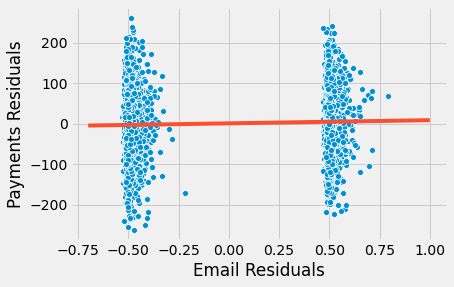

In [7]:
sns.scatterplot("res_email", "res_payments", data=residuals)
plt.plot(np.linspace(-0.7, 1), model_treatment.params[0] + np.linspace(-1, 2) * model_treatment.params[1], c="C1")
plt.xlabel("Email Residuals")
plt.ylabel("Payments Residuals");

Như tôi đã nói, chúng ta làm điều này chỉ theo lý thuyết. Trên thực tế, bạn có thể chỉ cần thêm các biến kiểm soát vào mô hình hồi quy cùng với sự can thiệp và các ước lượng sẽ hoàn toàn như nhau.

In [8]:
model_2 = smf.ols('payments ~ email + credit_limit + risk_score', data=data).fit()
model_2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,490.8653,9.715,50.527,0.000,471.820,509.911
email,4.4304,2.130,2.080,0.038,0.255,8.606
credit_limit,0.1511,0.008,18.833,0.000,0.135,0.167
risk_score,-8.0516,38.424,-0.210,0.834,-83.379,67.276


Tóm lại, bất cứ khi nào chúng ta có một biến kiểm soát mà dự đoán tốt được kết quả, ngay cả khi nó không phải là một biến nhiễu, việc thêm nó vào mô hình là một ý hay. Điều này giúp giảm bớt phương sai cho các ước lượng của tác động can thiệp. Dưới đây mô tả tình huống này bằng các đồ thị nhân quả.

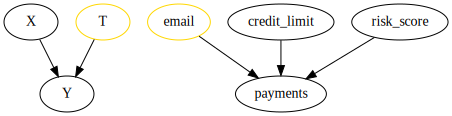

In [9]:
g = gr.Digraph()
g.edge("X", "Y"), g.edge("T", "Y")
g.node("T", color="gold")

g.node("email", color="gold")
g.edge("credit_limit", "payments")
g.edge("risk_score", "payments")
g.edge("email", "payments")

g

## Các Biến Kiểm soát Gần Như Nguy Hại

Trong một ví dụ khác, hãy xem xét một kịch bản thử nghiệm thuốc với 2 bệnh viện. Cả hai đều đang tiến hành các thử nghiệm ngẫu nhiên về một loại thuốc mới để điều trị một loại bệnh nhất định. Kết quả được quan tâm là số ngày nằm viện. Nếu can thiệp hiệu quả, nó sẽ làm giảm số ngày bệnh nhân nằm viện. Đối với một bệnh viện, chính sách liên quan đến can thiệp ngẫu nhiên là phát thuốc cho 90% bệnh nhân trong khi 10% còn lại dùng giả dược. Bệnh viện còn lại có một chính sách khác: họ phát thuốc cho 10% bệnh nhân ngẫu nhiên và 90% bệnh nhân nhận giả dược. Bạn cũng được biết rằng bệnh viện phát 90% thuốc thật và 10% giả dược thường nhận điều trị các ca nặng hơn.

In [10]:
hospital = pd.read_csv("./data/hospital_treatment.csv")
hospital.head()

,hospital,treatment,severity,days
0,1,1,29.686618,82
1,1,1,20.050340,57
2,1,1,20.302399,49
3,0,0,10.603118,44
4,0,0,8.332793,15


Vì bạn đang xử lý dữ liệu ngẫu nhiên, bạn chỉ cần chạy một hồi quy của kết quả theo sự can thiệp.

In [11]:
hosp_1 = smf.ols('days ~ treatment', data=hospital).fit()
hosp_1.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,33.2667,2.662,12.498,0.000,27.968,38.566
treatment,14.1533,3.367,4.204,0.000,7.451,20.856


Nhưng bạn lại thấy một kết quả trái ngược trực giác thông thường. Làm thế nào mà việc can thiệp lại làm tăng số ngày nằm viện? Câu trả lời nằm ở chỗ chúng ta đang chạy 2 thử nghiệm khác nhau. Mức độ nghiêm trọng của bệnh có liên quan cùng chiều với số ngày nằm viện và vì bệnh viện có nhiều ca bệnh nặng hơn phát nhiều thuốc hơn, việc sử dụng nhiều thuốc trở nên có tương quan với sự gia tăng của số ngày nằm viện. Khi ta xem xét cả hai bệnh viện, chúng ta có \\(E[Y_0|T=0]>E[Y_0|T=1]\\), nghĩa là, kết quả tiềm năng của nhóm đối chứng, tính bình quân, cao hơn so với nhóm can thiệp vì có nhiều người bệnh nhẹ không được nhận can thiệp trong bệnh viện hơn. Nói cách khác, mức độ nghiêm trọng của bệnh hoạt động như một biến nhiễu, quyết định bệnh viện nơi bệnh nhân đến điều trị và do đó, quyết định xác suất được nhận thuốc.

Có 2 cách để khắc phục điều đó. Cách đầu tiên là chỉ cần nhìn vào ATE ở mỗi bệnh viện riêng lẻ (tuy rằng cách này ngăn việc sử dụng dữ liệu từ cả hai bệnh viện).

In [12]:
hosp_2 = smf.ols('days ~ treatment', data=hospital.query("hospital==0")).fit()
hosp_2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,30.4074,2.868,10.602,0.000,24.523,36.292
treatment,-11.4074,10.921,-1.045,0.306,-33.816,11.001


In [13]:
hosp_3 = smf.ols('days ~ treatment', data=hospital.query("hospital==1")).fit()
hosp_3.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,59.0000,6.747,8.745,0.000,45.442,72.558
treatment,-10.3958,6.955,-1.495,0.141,-24.371,3.580


Trong trường hợp này, chúng ta đã có được một kết quả có lý cho ATE. Có vẻ như bây giờ việc dùng thuốc điều trị trên thực tế đang làm giảm số ngày nằm viện. Tuy nhiên, bởi vì ta đang xem xét từng bệnh viện riêng lẻ nên không có đủ các điểm dữ liệu. Do đó, chúng ta không thể có một kết quả mang ý nghĩa thống kê.

Một cách tiếp cận khác có thể tận dụng được sức mạnh của hồi quy, đó là kiểm soát mức độ nghiêm trọng của bệnh bằng cách đưa nó vào mô hình.

In [14]:
hosp_4 = smf.ols('days ~ treatment + severity', data=hospital).fit()
hosp_4.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,11.6641,2.000,5.832,0.000,7.681,15.647
treatment,-7.5912,2.269,-3.345,0.001,-12.110,-3.073
severity,2.2741,0.154,14.793,0.000,1.968,2.580


Câu hỏi đặt ra tiếp theo là chúng ta có nên đưa biến (phân loại) bệnh viện vào mô hình hay không? Sau cùng thì chúng ta cũng biết hai bệnh viện này chi phối can thiệp đúng không nào? Phải rồi, tuy nhiên một khi chúng ta đã kiểm soát được mức độ nghiêm trọng của bệnh thì bệnh viện không còn có tương quan với số ngày nằm viện nữa. Chúng ta biết rằng để là một biến nhiễu, biến đó phải gây ra cả sự can thiệp và kết quả. Trong trường hợp này, biến này chỉ tác động lên sự can thiệp.

Nhưng ta có thể kiểm soát nó để làm giảm phương sai, có phải vậy không? Chà, lại không đúng nữa rồi. Để một biến kiểm soát giảm bớt phương sai, nó phải đưa ra được dự đoán tốt về kết quả chứ không phải về sự can thiệp, đó chính là trường hợp này.

Tuy nhiên, ta vẫn muốn kiểm soát nó phải không? Nó có thể không có hại... Hay là có nhỉ?

In [15]:
hosp_5 = smf.ols('days ~ treatment + severity + hospital', data=hospital).fit()
hosp_5.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,11.0111,2.118,5.198,0.000,6.792,15.230
treatment,-5.0945,3.492,-1.459,0.149,-12.049,1.861
severity,2.3865,0.195,12.251,0.000,1.999,2.774
hospital,-4.1535,4.413,-0.941,0.350,-12.943,4.636


Thật đáng ngạc nhiên, nó lại có thể gây hại!

![img](./data/img/beyond-conf/shocked.png)

Việc thêm bệnh viện với vai trò là biến kiểm soát cùng với mức độ nghiêm trọng của bệnh làm gia tăng phương sai của ATE. Làm thế nào mà điều này lại có thể xảy ra? Câu trả lời nằm trong công thức tính sai số chuẩn của hệ số hồi quy.

$
\hat{\sigma}^2 = \dfrac{1}{n-2} \sum( y_i - \hat{y}_i )^2
$

$
\text{Var}(\hat{\beta}_2) = \dfrac{\sigma^2}{\sum(x_i - \bar{x})^2}
$

Từ công thức này, chúng ta có thể thấy rằng sai số chuẩn tỷ lệ nghịch với phương sai của biến \\(X\\). Điều này có nghĩa là, nếu \\(X\\) không thay đổi nhiều, ta sẽ khó ước lượng được tác động của nó đến kết quả. Điều này khá dễ hiểu. Đặt vào hoàn cảnh cực đoan và giả sử rằng bạn muốn ước lượng tác dụng của một loại thuốc, vì vậy bạn tiến hành một kiểm định với 10000 cá thể nhưng chỉ 1 trong số họ nhận can thiệp. Điều này sẽ làm cho việc xác định ATE trở nên rất khó khăn, chúng ta sẽ phải dựa vào việc so sánh một cá nhân với những người khác. Nói một cách khác chúng ta cần rất nhiều sự biến động trong kết quả của nhóm can thiệp để dễ dàng tìm ra tác động của nó.

Về lý do tại sao việc đưa bệnh viện vào trong mô hình lại làm tăng sai số đối với ước lượng, đó là bởi vì nó đưa ra dự đoán tốt về sự can thiệp chứ không phải về kết quả (một khi ta kiểm soát được mức độ nghiêm trọng của bệnh). Vì vậy, bằng việc dự đoán sự can thiệp, nó có hiệu quả làm cho phương sai thấp hơn! Một lần nữa, chúng ta có thể chia nhỏ phương pháp hồi quy ở trên thành 2 bước để thấy điều này.

In [16]:
model_treatment = smf.ols('treatment ~ severity + hospital', data=hospital).fit()
model_days = smf.ols('days ~ severity + hospital', data=hospital).fit()

residuals = pd.DataFrame(dict(res_days=model_days.resid, res_treatment=model_treatment.resid))

model_treatment = smf.ols('res_days ~ res_treatment', data=residuals).fit()

model_treatment.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.498e-14,0.827,3.02e-14,1.000,-1.646,1.646
res_treatment,-5.0945,3.447,-1.478,0.143,-11.957,1.768


In [17]:
print("Treatment Variance", np.var(hospital["treatment"]))
print("Treatment Residual Variance", np.var(residuals["res_treatment"]))

Treatment Variance 0.234375
Treatment Residual Variance 0.057529091872119076


Ngoài ra, đừng có hoàn toàn tin vào lời của tôi! Bạn nên kiểm tra xem công thức SE ở trên có đúng không:

In [18]:
sigma_hat = sum(model_treatment.resid**2)/(len(model_treatment.resid)-2)
var = sigma_hat/sum((residuals["res_treatment"] - residuals["res_treatment"].mean())**2)
print("SE of the Coeficient:", np.sqrt(var))

SE of the Coeficient: 3.4469737674869028


Vì vậy, điểm mấu chốt là chúng ta nên thêm các biến kiểm soát có tương quan với cả sự can thiệp và kết quả (biến nhiễu), giống như mức độ nghiêm trọng của bệnh trong mô hình trên. Chúng ta cũng nên thêm các biến kiểm soát đưa ra dự đoán tốt về kết quả, ngay cả khi chúng không phải là biến nhiễu, vì chúng làm giảm phương sai của các ước lượng. Tuy nhiên, chúng ta **KHÔNG NÊN** thêm các biến kiểm soát chỉ dự đoán tốt về sự can thiệp, vì chúng sẽ làm tăng phương sai của các ước lượng.

Dưới đây mô tả tình huống này bằng các đồ thị nhân quả.

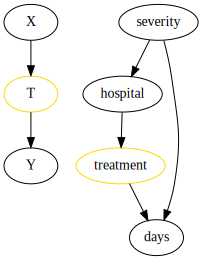

In [19]:
g = gr.Digraph()

g.edge("X", "T"), g.edge("T", "Y")
g.node("T", color="gold")

g.node("treatment", color="gold")
g.edge("severity", "hospital")
g.edge("severity", "days")
g.edge("hospital", "treatment")
g.edge("treatment", "days")

g

## Các Biến Kiểm soát Tệ - Thiên Lệch Chọn

Hãy quay lại ví dụ về thư điện tử dùng để thu nợ. Hãy nhớ rằng email đã được chỉ định gửi ngẫu nhiên đến khách hàng. Chúng ta đã giải thích `credit_limit` và `risk_score` là gì. Bây giờ, chúng ta hãy xem xét các biến còn lại: `opened`. Đây là một biến giả cho việc khách hàng có mở thư điện tử hay không và `agreement` là một biến giả khác đánh dấu nếu khách hàng liên hệ với bộ phận thu nợ để thương lượng khoản vay sau khi nhận được thư. Bạn nghĩ mô hình nào sau đây phù hợp hơn? Đầu tiên là một mô hình với biến can thiệp là `credit_limit` và `risk_score`; thứ hai là thêm các biến giả `opened` và `agreement`.

In [20]:
email_1 = smf.ols('payments ~ email + credit_limit + risk_score', data=data).fit()
email_1.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,490.8653,9.715,50.527,0.000,471.820,509.911
email,4.4304,2.130,2.080,0.038,0.255,8.606
credit_limit,0.1511,0.008,18.833,0.000,0.135,0.167
risk_score,-8.0516,38.424,-0.210,0.834,-83.379,67.276


In [21]:
email_2 = smf.ols('payments ~ email + credit_limit + risk_score + opened + agreement', data=data).fit()
email_2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,488.4416,9.716,50.272,0.000,469.394,507.489
email,-1.6095,2.724,-0.591,0.555,-6.949,3.730
credit_limit,0.1507,0.008,18.809,0.000,0.135,0.166
risk_score,-2.0929,38.375,-0.055,0.957,-77.325,73.139
opened,3.9808,3.914,1.017,0.309,-3.692,11.654
agreement,11.7093,4.166,2.811,0.005,3.542,19.876


Trong khi mô hình đầu tiên cho thấy kết quả có ý nghĩa thống kê cho biến email, mô hình thứ hai lại không như vậy. Nhưng có lẽ mô hình thứ hai là mô hình phù hợp và email không có tác dụng gì cả. Rốt cuộc, mô hình này kiểm soát nhiều yếu tố hơn, vì vậy có phải nó sẽ mạnh hơn hay không? Bây giờ có lẽ bạn cũng biết rằng điều đó không đúng. Điều cần phải làm lúc này là tìm ra yếu tố giúp cho mô hình này mạnh.

Chúng ta biết rằng chúng ta PHẢI thêm các biến nhiễu, các biến mà tác động lên cả sự can thiệp và kết quả. Chúng ta cũng biết rằng nên thêm các biến kiểm soát đưa ra dự đoán tốt về kết quả. Điều này không bắt buộc, nhưng thật tuyệt khi ta sở hữu chúng. Chúng ta cũng biết rằng việc thêm các biến kiểm soát chỉ đưa ra dự đoán về sự can thiệp là một ý tưởng tồi. Xin nhắc lại, đây không phải là một tội lỗi chết người, nhưng tốt hơn hết là ta nên tránh. Vậy thì `opened` và `agreement` thuộc loại biến kiểm soát nào? Hóa ra chúng không thuộc loại nào cả.

Bạn nghĩ thử xem, các biến `opened` và `agreement` chắc chắn có tương quan với email, vì sau cùng thì bạn không thể mở email nếu bạn không nhận được nó và chúng ta cũng đã nói rằng biến `agreement` chỉ cân nhắc việc thương lượng giá, điều mà chỉ xảy ra sau khi email đã được gửi đi. Nhưng **chúng không tác động lên email! Thay vào đó, chúng bị tác động bởi nó!**

Bất cứ khi nào tôi cần hiểu loại biến số mà tôi đang phải đối phó, tôi luôn tìm đến đồ thị nhân quả. Hãy biểu diễn chúng tại đây

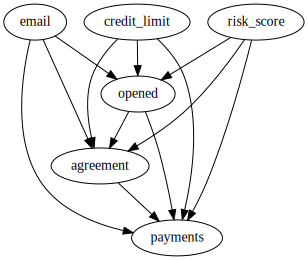

In [22]:
g = gr.Digraph()


g.edge("email", "payments")
g.edge("email", "opened")
g.edge("email", "agreement")
g.edge("opened", "payments")
g.edge("opened", "agreement")
g.edge("agreement", "payments")

g.edge("credit_limit", "payments")
g.edge("credit_limit", "opened")
g.edge("credit_limit", "agreement")
g.edge("risk_score", "payments")
g.edge("risk_score", "opened")
g.edge("risk_score", "agreement")

g

Chúng ta biết không có gì tác động việc gửi email vì nó được thiết kế ngẫu nhiên. Và chúng ta biết (hoặc ít nhất ta có lý do chính đáng để tin như vậy) rằng hạn mức tín dụng và rủi ro tác động đến lượng thanh toán. Chúng ta cũng nghĩ rằng email tác động đến lượng thanh toán. Đối với `opened`, chúng ta tin rằng nó có tác động lên lượng thanh toán. Theo trực giác, những người đã mở email sẽ sẵn sàng thương lượng và trả nợ hơn. Chúng ta cũng nghĩ rằng `opened` tác động lên `agreement` vì những lý do tương tự như nó tác động lên lượng thanh toán. Hơn nữa, chúng ta biết `opened` là do tác động của `email` và chúng ta có lý do để tin rằng những người có rủi ro và hạn mức tín dụng khác nhau có tỷ lệ mở email khác nhau, vì vậy hạn mức tín dụng và rủi ro cũng tác động lên `opened`. Đối với `agreement`, chúng ta cũng nghĩ rằng nó được tác động bởi `opened`. Nếu chúng ta nghĩ về biến phụ thuộc `payment`, ta có thể thấy đó là một kết quả hình phễu:

$
email -> opened -> agreement -> payment 
$

Chúng ta cũng nghĩ rằng các mức độ rủi ro và hạn mức tín dụng khác nhau có xu hướng dẫn đến việc thương lượng trả nợ là khác nhau, vì vậy chúng ta sẽ đánh dấu chúng là có tác động lên `agreement`. Đối với email và `agreement`, chúng ta có thể đưa ra lập luận rằng một số người chỉ đọc chủ đề và đồng ý trả nợ, vì vậy nó cũng có thể dẫn đến việc thỏa thuận mà không cần mở email.

Những gì chúng ta nhận thấy về biểu đồ này là `opened` và `agreement` đều thuộc đường nhân quả từ email đến payment. Vì vậy, nếu chúng ta kiểm soát chúng bằng hồi quy, chúng ta sẽ nói "đây là tác động của email khi ta cố định các biến opened và agreement". Tuy nhiên, cả hai đều là một phần trong tác tác động nhân quả của email, vì vậy chúng ta không muốn giữ chúng cố định. Thay vào đó, chúng ta có thể tranh luận rằng email làm tăng lượng thanh toán một cách chính xác vì nó thúc đẩy tỷ lệ thỏa thuận. Nếu chúng ta cố định những biến đó, ta đang xóa bỏ một số tác động thực ra khỏi email.

Với ký hiệu kết quả tiềm năng, chúng ta có thể nói như vậy nhờ vào việc ngẫu nhiên hóa \\(E[Y_0|T=0] = E[Y_0|T=1]\\). Tuy nhiên, ngay cả với sự ngẫu nhiên, khi chúng ta kiểm soát `agreement`, nhóm can thiệp và nhóm đối chứng không còn tương đồng nữa. Trên thực tế, trực giác mách bảo rằng, chúng ta thậm chí có thể dự đoán được chúng khác nhau như thế nào:

$
E[Y_0|T=0, Agreement=0] > E[Y_0|T=1, Agreement=0]
$

$
E[Y_0|T=0, Agreement=1] > E[Y_0|T=1, Agreement=1]
$

Phương trình đầu tiên cho thấy những người không được nhận email và thỏa thuận cho kết quả tốt hơn những người nhận email và không có thỏa thuận. Đó là bởi vì, nếu việc can thiệp có tác động tích cực, những người không thương lượng **ngay cả khi nhận được email** có khả năng trả nợ thấp hơn so với những người không thương lượng nhưng cũng không nhận được cú hích từ email. Đối với phương trình thứ hai, những người thương lượng ngay cả khi không nhận được sự can thiệp có lẽ thực hiện tốt hơn những người đã thương lượng nhờ vào tác động của email.

Điều này có thể rất khó hiểu khi bạn đọc lần đầu (kể cả chúng tôi cũng vậy), nhưng hãy chắc chắn rằng bạn hiểu được nó. Bạn nên đọc lại nếu cần thiết. Sau đó, một kiểu lập luận tương tự có thể được thực hiện với biến opened. Bạn hãy tự suy luận trong trường hợp này.

Loại thiên lệch này rất cứng đầu và nó có tên gọi riêng. Mặc dù nhiễu là thiên lệch do không kiểm soát được vì một nguyên nhân chung, **thiên lệch chọn là khi ta kiểm soát một tác động chung hoặc một biến nằm giữa đường đi từ nguyên nhân đến kết quả**. Theo luật bất thành văn, hãy luôn đưa các biến nhiễu và các biến đưa ra dự đoán tốt về \\(Y\\) vào mô hình. Luôn loại bỏ các biến chỉ dự báo tốt về \\(T\\), các biến trung gian giữa sự can thiệp và kết quả hoặc các kết quả chung của biến can thiệp và kết quả.

![img](./data/img/beyond-conf/selection.png)

Thiên lệch chọn cứng đầu đến mức ngay cả thử nghiệm ngẫu nhiên cũng không thể khắc phục được, hoặc hơn thế nữa, nó thường bị bắt gặp ở những gã gà mờ khi sử dụng dữ liệu ngẫu nhiên. Phát hiện và tránh thiên lệch chọn đòi hỏi thực hành nhiều hơn kỹ năng. Thông thường, chúng xuất hiện dưới một số ý tưởng được cho là thông minh, khiến việc xác định chúng càng khó hơn. Dưới đây là một số ví dụ về thiên lệch chọn mà tôi đã gặp:

    1. Thêm một biến giả cho việc thanh toán toàn bộ khoản nợ khi cố gắng ước lượng tác động của chiến lược thu nợ đối với lượng thanh toán.
    2. Kiểm soát các biến tính chất công việc đầu ra (văn phòng hoặc chân tay) khi cố gắng ước lượng tác động của giáo dục đối với thu nhập.
    3. Kiểm soát biến chuyển đổi khi ước lượng tác động của lãi suất đến thời hạn vay.
    4. Kiểm soát hạnh phúc hôn nhân khi ước lượng tác động của con cái đối với các vấn đề ngoài hôn nhân.
    5. Chia nhỏ mô hình thanh toán E[Thanh toán] thành một mô hình nhị phân dự đoán liệu thanh toán có xảy ra hay không và một mô hình khác dự đoán khoản thanh toán sẽ diễn ra với điều kiện: E[Thanh toán|Thanh toán>0]*P(Thanh toán>0).
    
Điều đáng chú ý về tất cả những ý tưởng này nằm ở chỗ chúng nghe rất hợp lý. Thiên lệch chọn thường như vậy. Hãy xem đây như một lời cảnh báo. Trên thực tế, bản thân tôi đã từng rơi vào những cái bẫy như trên rất nhiều lần trước khi biết được chúng tệ như thế nào. Trong số các trường hợp trên, thì trường hợp cuối đáng được giải thích thêm vì nó có vẻ thật thông minh và khiến nhiều nhà khoa học dữ liệu mất cảnh giác. Nó có sức lan tỏa đến mức nó được đặt tên riêng: **Cố định Kết quả Tích cực**!

### Cố định Kết quả Tích cực

Tình hình diễn ra như thế này. Bạn có một biến liên tục mà bạn muốn dự đoán nhưng phân phối của nó tập trung quá nhiều tại 0. Ví dụ: nếu bạn muốn lập mô hình chi tiêu của người tiêu dùng, bạn sẽ có thứ gì đó giống với phân phối gamma, nhưng với rất nhiều số 0.

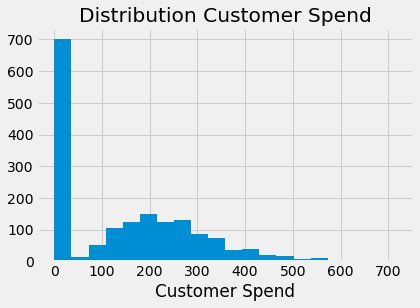

In [23]:
plt.hist(np.concatenate([
    np.random.gamma(5, 50, 1000), 
    np.zeros(700)
]), bins=20)
plt.xlabel("Customer Spend")
plt.title("Distribution Customer Spend");

Khi một chuyên gia dữ liệu nhìn thấy điều này, ý tưởng đầu tiên nảy ra trong đầu anh ta là chia mô hình thành 2 bước. Đầu tiên là mô hình sự tham gia, nghĩa là xác suất để \\(Y > 0\\). Trong ví dụ về chi tiêu, điều này sẽ được lập mô hình nếu khách hàng quyết định chi hay không. Phần thứ hai lập mô hình \\(Y\\) cho những người đã quyết định tham gia. Đó là Cố định Kết quả Tích cực. Trong trường hợp này, đây sẽ là số tiền khách hàng chi tiêu sau khi họ quyết định sẽ chi tiêu vào bất cứ thứ gì. Nếu chúng ta muốn ước lượng tác động của sự can thiệp \\(T\\) đối với chi tiêu, nó sẽ được biểu diễn theo cách tiếp cận gồm hai mô hình như sau

$
E[Y_i|T_i] = E[Y_i|Y_i>0, T_i]P(Y_i>0|T_i)
$

Không có gì sai đối với mô hình tham gia \\(P(Y_i>0|T_i)\\). Trên thực tế, nếu \\(T\\) được chỉ định ngẫu nhiên, hệ số của nó sẽ phản ánh sự gia tăng trong xác suất chi tiêu do có sự can thiệp. Vấn đề nằm ở phần COP. **Nó sẽ bị thiên lệch ngay cả khi được chỉ định ngẫu nhiên**:

\begin{align*} 
E[Y_i|Y_i>0, T_i]&=E[Y_i|Y_i>0, T_i=1]-E[Y_i|Y_i>0, T_i=0] \\
&=E[Y_{i1}|Y_{i1}>0]-E[Y_{i0}|Y_{i0}>0] \\
&=\underbrace{E[Y_{i1} - Y_{i0}|Y_{i1}>0]}_{Causal \ Effect} + \underbrace{\{ E[Y_{i0}|Y_{i1}>0] - E[Y_{i0}|Y_{i0}>0] \}}_{Selection \ Bias}
\end{align*} 

Khi phân tích hiệu ứng COP, đầu tiên chúng ta xác định được tác động nhân quả đối với những người tham gia. Trong ví dụ này, đây sẽ là tác động nhân quả đối với những người quyết định chi tiêu. Hai là, chúng ta có một thiên lệch, chính là sự khác biệt đối với \\(Y_0\\) cho những người quyết định tham gia sự can thiệp (\\(E[Y_{i0}|Y_{i1}>0]\\)) và những người tham gia ngay cả khi không có sự can thiệp (\\(E[Y_{i0}|Y_{i0}>0]\\)). Trong trường hợp này, thiên lệch này có thể âm, vì những người chi tiêu khi phải có can thiệp, nếu đặt trong trường hợp không nhận được sự can thiệp, có thể sẽ chi tiêu ít hơn những người chi tiêu ngay cả khi không có sự can thiệp \\(E[Y_{i0}|Y_{i1}>0] < E[Y_{i0}|Y_{i0}>0]\\).

![img](./data/img/beyond-conf/cop.png)

Tóm tắt lại về thiên lệch chọn, chúng ta cần phải luôn nhắc nhở bản thân không bao giờ kiểm soát một biến nằm giữa sự can thiệp và kết quả hoặc là kết quả chung của cả kết quả và sự can thiệp. Theo ngôn ngữ đồ thị, biến kiểm soát tệ sẽ được biểu diễn như sau:

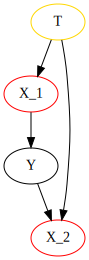

In [24]:
g = gr.Digraph()

g.edge("T", "X_1"), g.node("T", color="gold"), g.edge("X_1", "Y"), g.node("X_1", color="red")
g.edge("T", "X_2"), g.edge("Y", "X_2"), g.node("X_2", color="red")

g

## Ý tưởng chủ đạo

Trong phần này, chúng ta đã tìm hiểu các biến không phải biến nhiễu và liệu chúng ta có nên thêm chúng vào mô hình hay không khi xác định quan hệ nhân quả. Chúng ta nhận thấy rằng các biến đưa ra dự đoán tốt về kết quả \\(y\\) nên được thêm vào mô hình ngay cả khi chúng không dự đoán \\(T\\) (không phải là các biến nhiễu). Điều này là do việc dự đoán \\(Y\\) làm giảm phương sai và dẫn đến nhiều khả năng thu được kết quả có ý nghĩa thống kê hơn khi ước lượng tác động nhân quả. Tiếp theo, chúng ta thấy rằng việc thêm các biến nhằm dự đoán sự can thiệp nhưng không dự đoán kết quả là một ý tưởng tồi. Những biến đó làm giảm sự biến động của can thiệp, khiến chúng ta khó tìm ra tác động nhân quả. Cuối cùng, chúng ta đã xem xét thiên lệch chọn. Thiên lệch này nảy sinh khi ta kiểm soát các biến số trong đường nhân quả từ sự can thiệp đến kết quả hoặc các biến là kết quả chung của cả can thiệp và kết quả.

## Tài liệu tham khảo

Tôi muốn dành loạt bài viết này để vinh danh Joshua Angrist, Alberto Abadie and Christopher Walters vì khóa học Kinh tế lượng tuyệt cú mèo của họ. Phần lớn ý tưởng trong loạt bài này được lấy từ các bài giảng của họ được tổ chức bởi Hiệp hội Kinh tế Mĩ.  Theo dõi các bài giảng này là những gì tôi làm trong suốt năm 2020 khó nhằn.
* [Kinh tế lượng với dữ liệu chéo](https://www.aeaweb.org/conference/cont-ed/2017-webcasts)
* [Luyện chưởng Kinh tế lượng Gần như Vô hại](https://www.aeaweb.org/conference/cont-ed/2020-webcasts)

Tôi cũng muốn giới thiệu cuốn sách lý thú của Angrist. Chúng cho tôi thấy Kinh tế lượng, hoặc 'Lượng theo cách họ gọi không chỉ vô cùng hữu ích mà còn rất vui.

* [Kinh tế lượng Gần như Vô hại](https://www.mostlyharmlesseconometrics.com/)
* [Luyện chưởng 'Lượng](https://www.masteringmetrics.com/)

Tài liệu tham khảo cuối cùng của tôi là cuốn sách của Miguel Hernan and Jamie Robins. Nó là người bạn đồng hành tin cậy với tôi khi trả lời những câu hỏi nhân quả khó nhằn.

* [Sách Suy Luận Nhân Quả](https://www.hsph.harvard.edu/miguel-hernan/causal-inference-book/)

# Bảng Từ Viết tắt 
|Viết tắt| Tiếng Anh | Tiếng Việt |
| --- | --- | --- | 
|ATE|Average Treatment Effect|Tác động Can thiệp Trung bình| 


# Bảng Thuật ngữ 
| Thuật ngữ | Tiếng Anh |
| --- | --- | 
|biến|variable| 
|biến can thiệp|treatment variable| 
|biến giả|dummy, dummy variable| 
|biến liên tục|continuous variable| 
|biến nhiễu|confounder, confounding variable| 
|biến phụ thuộc|dependent variable| 
|biến trung gian|mediator, intermediary variable| 
|chuyên gia dữ liệu|data scientist| 
|có tương quan|correlated| 
|dữ liệu lớn|big data| 
|dữ liệu ngẫu nhiên|random data| 
|giá trị trung bình|mean| 
|hệ số hồi quy|regression coefficient| 
|hồi quy|regression, regress| 
|hồi quy tuyến tính|linear regression| 
|khoảng tin cậy|confidence interval| 
|kết quả tiềm năng|potential outcome| 
|mô hình hồi quy|regression model| 
|mô hình nhị phân|binary model| 
|mạnh|robust| 
|nhiễu|confounding| 
|nhóm được can thiệp|treatment group, test group| 
|nhóm đối chứng|control group, untreated group| 
|phân phối|distribution| 
|phân phối gamma|gamma distribution| 
|phương sai|variance| 
|phần dư|error term, residual| 
|sai số|error| 
|sai số chuẩn|standard error| 
|thiên lệch|bias| 
|thiên lệch chọn|selection bias| 
|thử nghiệm ngẫu nhiên|randomised trial| 
|trị số p|p-value| 
|tác động can thiệp|treatment effect, treatment impact| 
|tác động can thiệp trung bình|average treatment effect| 
|ý nghĩa thống kê|statistical significance| 
|điểm dữ liệu|data point| 
|đường hồi quy|fitted line, regression line| 
|đường nhân quả|causal path| 
|đối chứng|untreated, non-treated| 
